In [1]:
# In your notebook or feature_engineering.py
import pandas as pd
import os
import sys
from pathlib import Path

In [2]:
import os
import sys

# Get the notebook's directory (e.g., AmbiguityAssault/noteboooks)
NOTEBOOK_DIR = os.getcwd()

# Set the project root (parent of noteboooks/)
PROJECT_ROOT = os.path.abspath(os.path.join(NOTEBOOK_DIR, '..'))

# Add project root to Python path so `src` is available
if PROJECT_ROOT not in sys.path:
    sys.path.insert(0, PROJECT_ROOT)
# sys.path.insert(0, PROJECT_ROOT)

print("PYTHONPATH:", sys.path)  # Debugging

from src.config import RAW_NEWS_DIR, PROCESSED_DATA_DIR, SENTIMENT_MODEL_NAME, DEVICE, TICKERS, DATASET_DIR
from src.sentiment_analyzer import SentimentAnalyzer # Make sure this can be imported

# Create processed data directory if it doesn't exist
PROCESSED_DATA_DIR.mkdir(parents=True, exist_ok=True)

print(TICKERS)
print(SENTIMENT_MODEL_NAME)
print(DEVICE)
print(RAW_NEWS_DIR)
print(PROCESSED_DATA_DIR)

PYTHONPATH: ['/data3/pratyush.jena/misc/AmbiguityAssault', '/home/pratyush.jena/miniconda3/envs/ins_dec/lib/python311.zip', '/home/pratyush.jena/miniconda3/envs/ins_dec/lib/python3.11', '/home/pratyush.jena/miniconda3/envs/ins_dec/lib/python3.11/lib-dynload', '', '/home/pratyush.jena/miniconda3/envs/ins_dec/lib/python3.11/site-packages']


/home/pratyush.jena/miniconda3/envs/ins_dec/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


['AAPL', 'AMZN', 'NVDA', 'TSLA', 'NKE']
yiyanghkust/finbert-tone
cuda
/data3/pratyush.jena/misc/AmbiguityAssault/dataset/cleaned
/data3/pratyush.jena/misc/AmbiguityAssault/dataset/processed_fintone


In [3]:
# Initialize sentiment analyzer
analyzer = SentimentAnalyzer(model_name=SENTIMENT_MODEL_NAME, device=DEVICE)

for ticker in TICKERS:
    print(f"Processing news for {ticker}...")
    news_file_path = RAW_NEWS_DIR / f"{ticker}_alpha_news_data.csv" # Adjust filename as needed
    
    if not news_file_path.exists():
        print(f"News file not found for {ticker}: {news_file_path}")
        continue

    try:
        news_df = pd.read_csv(news_file_path)
    except Exception as e:
        print(f"Error reading {news_file_path}: {e}")
        continue

    # 1. Combine title and summary
    news_df['news_text'] = news_df['title'].fillna('') + " " + news_df['summary'].fillna('')

    # 2. Basic Cleaning of news_text
    news_df['news_text'] = news_df['news_text'].str.lower()
    # Add more cleaning if needed (e.g., remove URLs, special characters)
    # news_df['news_text'] = news_df['news_text'].str.replace(r'http\S+', '', regex=True)

    # 3. Apply Sentiment Analysis (using the class we defined)
    if 'news_text' in news_df.columns and not news_df['news_text'].dropna().empty:
        news_df_with_sentiment = analyzer.add_sentiment_to_df(news_df, text_column_name='news_text')
    else:
        print(f"No 'news_text' to analyze for {ticker}. Skipping sentiment analysis.")
        # Add empty sentiment columns if needed for schema consistency later
        news_df_with_sentiment = news_df.copy()
        for col in ['sa_positive', 'sa_negative', 'sa_neutral']: # Adjust if you have compound etc.
            news_df_with_sentiment[col] = np.nan


    # 4. Parse 'published_date' for daily aggregation later
    # Ensure consistent datetime parsing, handling potential errors
    try:
        news_df_with_sentiment['datetime_utc'] = pd.to_datetime(news_df_with_sentiment['published_date'], format='%Y%m%dT%H%M%S', utc=True)
        news_df_with_sentiment['date'] = news_df_with_sentiment['datetime_utc'].dt.date
    except ValueError as e:
        print(f"Error parsing 'published_date' for {ticker}. Some dates might be NaT. Error: {e}")
        # Fallback or attempt other formats if necessary, or drop problematic rows
        news_df_with_sentiment['datetime_utc'] = pd.to_datetime(news_df_with_sentiment['published_date'], errors='coerce', utc=True)
        news_df_with_sentiment['date'] = news_df_with_sentiment['datetime_utc'].dt.date


    # 5. Save Processed News Data
    output_path = PROCESSED_DATA_DIR / f"{ticker}_news_processed.csv"
    news_df_with_sentiment.to_csv(output_path, index=False)
    print(f"Saved processed news for {ticker} to {output_path}")
    print(news_df_with_sentiment.head())

print("News preprocessing and sentiment analysis complete for all tickers.")

Processing news for AAPL...


Analyzing Sentiment: 100%|██████████| 609/609 [00:33<00:00, 18.13it/s]


Saved processed news for AAPL to /data3/pratyush.jena/misc/AmbiguityAssault/dataset/processed_fintone/AAPL_news_processed.csv
    published_date                                              title  \
0  20220401T060314  US antitrust chiefs pledge to crackdown on Big...   
1  20220401T090100  The 2022 Chrysler Pacifica Hybrid minivan: Thi...   
2  20220401T101419  Jim Cramer Blasts Germany For Not Doing Enough...   
3  20220401T101757  BTIG Remains Bullish On CoreCard Despite Apple...   
4  20220401T102008  Is Schwab Fundamental U.S. Large Company Index...   

                                             summary ticker  \
0  US antitrust chiefs voiced support for an Amer...   AAPL   
1  Run the kids to school without using gas, but ...   AAPL   
2  CNBC host Jim Cramer furiously tweeted that Ge...   AAPL   
3  The news of Apple Inc ( NASDAQ: AAPL ) develop...   AAPL   
4                     Smart Beta ETF report for FNDX   AAPL   

   ticker_sentiment_score ticker_sentiment_label  \
0   

Analyzing Sentiment: 100%|██████████| 486/486 [00:24<00:00, 19.51it/s]


Saved processed news for AMZN to /data3/pratyush.jena/misc/AmbiguityAssault/dataset/processed_fintone/AMZN_news_processed.csv
    published_date                                              title  \
0  20220301T080000  Nasdaq moves into positive territory as broade...   
1  20220301T212653                     When Is Amazon Prime Day 2022?   
2  20220303T172517    Are You an Investor Needing Some Calm Guidance?   
3  20220303T201500  4 Semiconductor Stocks For Your March 2022 Wat...   
4  20220304T114200  Foot Locker Has Been Thrown on the Clearance R...   

                                             summary ticker  \
0  Live updates: Dow tumbles as Russia threatens ...   AMZN   
1  Bargain hunters know the annual Amazon Prime D...   AMZN   
2                                         Read this.   AMZN   
3  Do you have these semiconductor stocks on your...   AMZN   
4  Shares of Foot Locker have fallen sharply base...   AMZN   

   ticker_sentiment_score ticker_sentiment_label  \
0   

Analyzing Sentiment: 100%|██████████| 484/484 [00:24<00:00, 19.36it/s]


Saved processed news for NVDA to /data3/pratyush.jena/misc/AmbiguityAssault/dataset/processed_fintone/NVDA_news_processed.csv
    published_date                                              title  \
0  20220303T065619  MarketingPulse and eTailingPulse to shed light...   
1  20220303T210336                 20 Stocks Billionaires Are Selling   
2  20220304T172200          The Top 5 Investment Plays for Blockchain   
3  20220304T193600  Nvidia Faces an Unusual Demand That Threatens ...   
4  20220306T000000  Amid Russia's war, America Inc reckons with th...   

                                             summary ticker  \
0  [Sponsored Article] The Covid-19 pandemic has ...   NVDA   
1  A lot of money continues to flow into hedge fu...   NVDA   
2  There are plenty of ways to invest in blockcha...   NVDA   
3  The chip giant was recently the victim of a hack.   NVDA   
4  Multinational companies grapple with a fractur...   NVDA   

   ticker_sentiment_score ticker_sentiment_label  \
0   

Analyzing Sentiment: 100%|██████████| 708/708 [00:40<00:00, 17.64it/s]


Saved processed news for TSLA to /data3/pratyush.jena/misc/AmbiguityAssault/dataset/processed_fintone/TSLA_news_processed.csv
    published_date                                              title  \
0  20220301T080000  Tesla Rival Slashes 2022 Production Outlook; L...   
1  20220301T080000  Nasdaq moves into positive territory as broade...   
2  20220301T113014  BYD to use Baidu's autonomous driving technolo...   
3  20220301T163019  Chinese electric car makers' February sales de...   
4  20220302T080000  Box Stock Jumps As Fourth-Quarter Results, Out...   

                                             summary ticker  \
0  Lucid Stock Sinks As Tesla Rival Slashes 2022 ...   TSLA   
1  Live updates: Dow tumbles as Russia threatens ...   TSLA   
2  BYD, China's biggest electric vehicle (EV) bui...   TSLA   
3  China's three biggest makers of smart electric...   TSLA   
4  Box Stock Jumps As Earnings Beat Estimates Inv...   TSLA   

   ticker_sentiment_score ticker_sentiment_label  \
0   

Analyzing Sentiment: 100%|██████████| 260/260 [00:13<00:00, 19.01it/s]


Saved processed news for NKE to /data3/pratyush.jena/misc/AmbiguityAssault/dataset/processed_fintone/NKE_news_processed.csv
    published_date                                              title  \
0  20220301T210525  Stocks making the biggest moves midday: Target...   
1  20220301T212115  Kohl's issues better-than-expected outlook as ...   
2  20220302T020013  Apple halts product sales in Russia after Ukra...   
3  20220302T080000  Rich Russians turn to luxury jewellery, watche...   
4  20220302T194621   This Social Club Runs on Crypto Tokens and Vibes   

                                             summary ticker  \
0  These are the stocks posting the largest moves...    NKE   
1  CEO Michelle Gass said Kohl's achieved an oper...    NKE   
2  Apple Inc halted sales of the iPhone and its o...    NKE   
3  With sanctions on Russia sending the ruble plu...    NKE   
4  Friends With Benefits is a V.I.P. lounge for c...    NKE   

   ticker_sentiment_score ticker_sentiment_label  \
0     

In [4]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path

sns.set(style='whitegrid')


In [5]:
processed_dir = PROCESSED_DATA_DIR  # already defined in your script

# Combine all processed news data into one DataFrame
dfs = []
for ticker in TICKERS:
    path = processed_dir / f"{ticker}_news_processed.csv"
    if path.exists():
        df = pd.read_csv(path, parse_dates=["datetime_utc"])
        df["ticker"] = ticker
        dfs.append(df)

if not dfs:
    raise ValueError("No processed files found.")

combined_df = pd.concat(dfs, ignore_index=True)
print(f"Loaded {len(combined_df)} rows.")


Loaded 81451 rows.


/data3/pratyush.jena/misc/AmbiguityAssault/dataset/processed_fintone


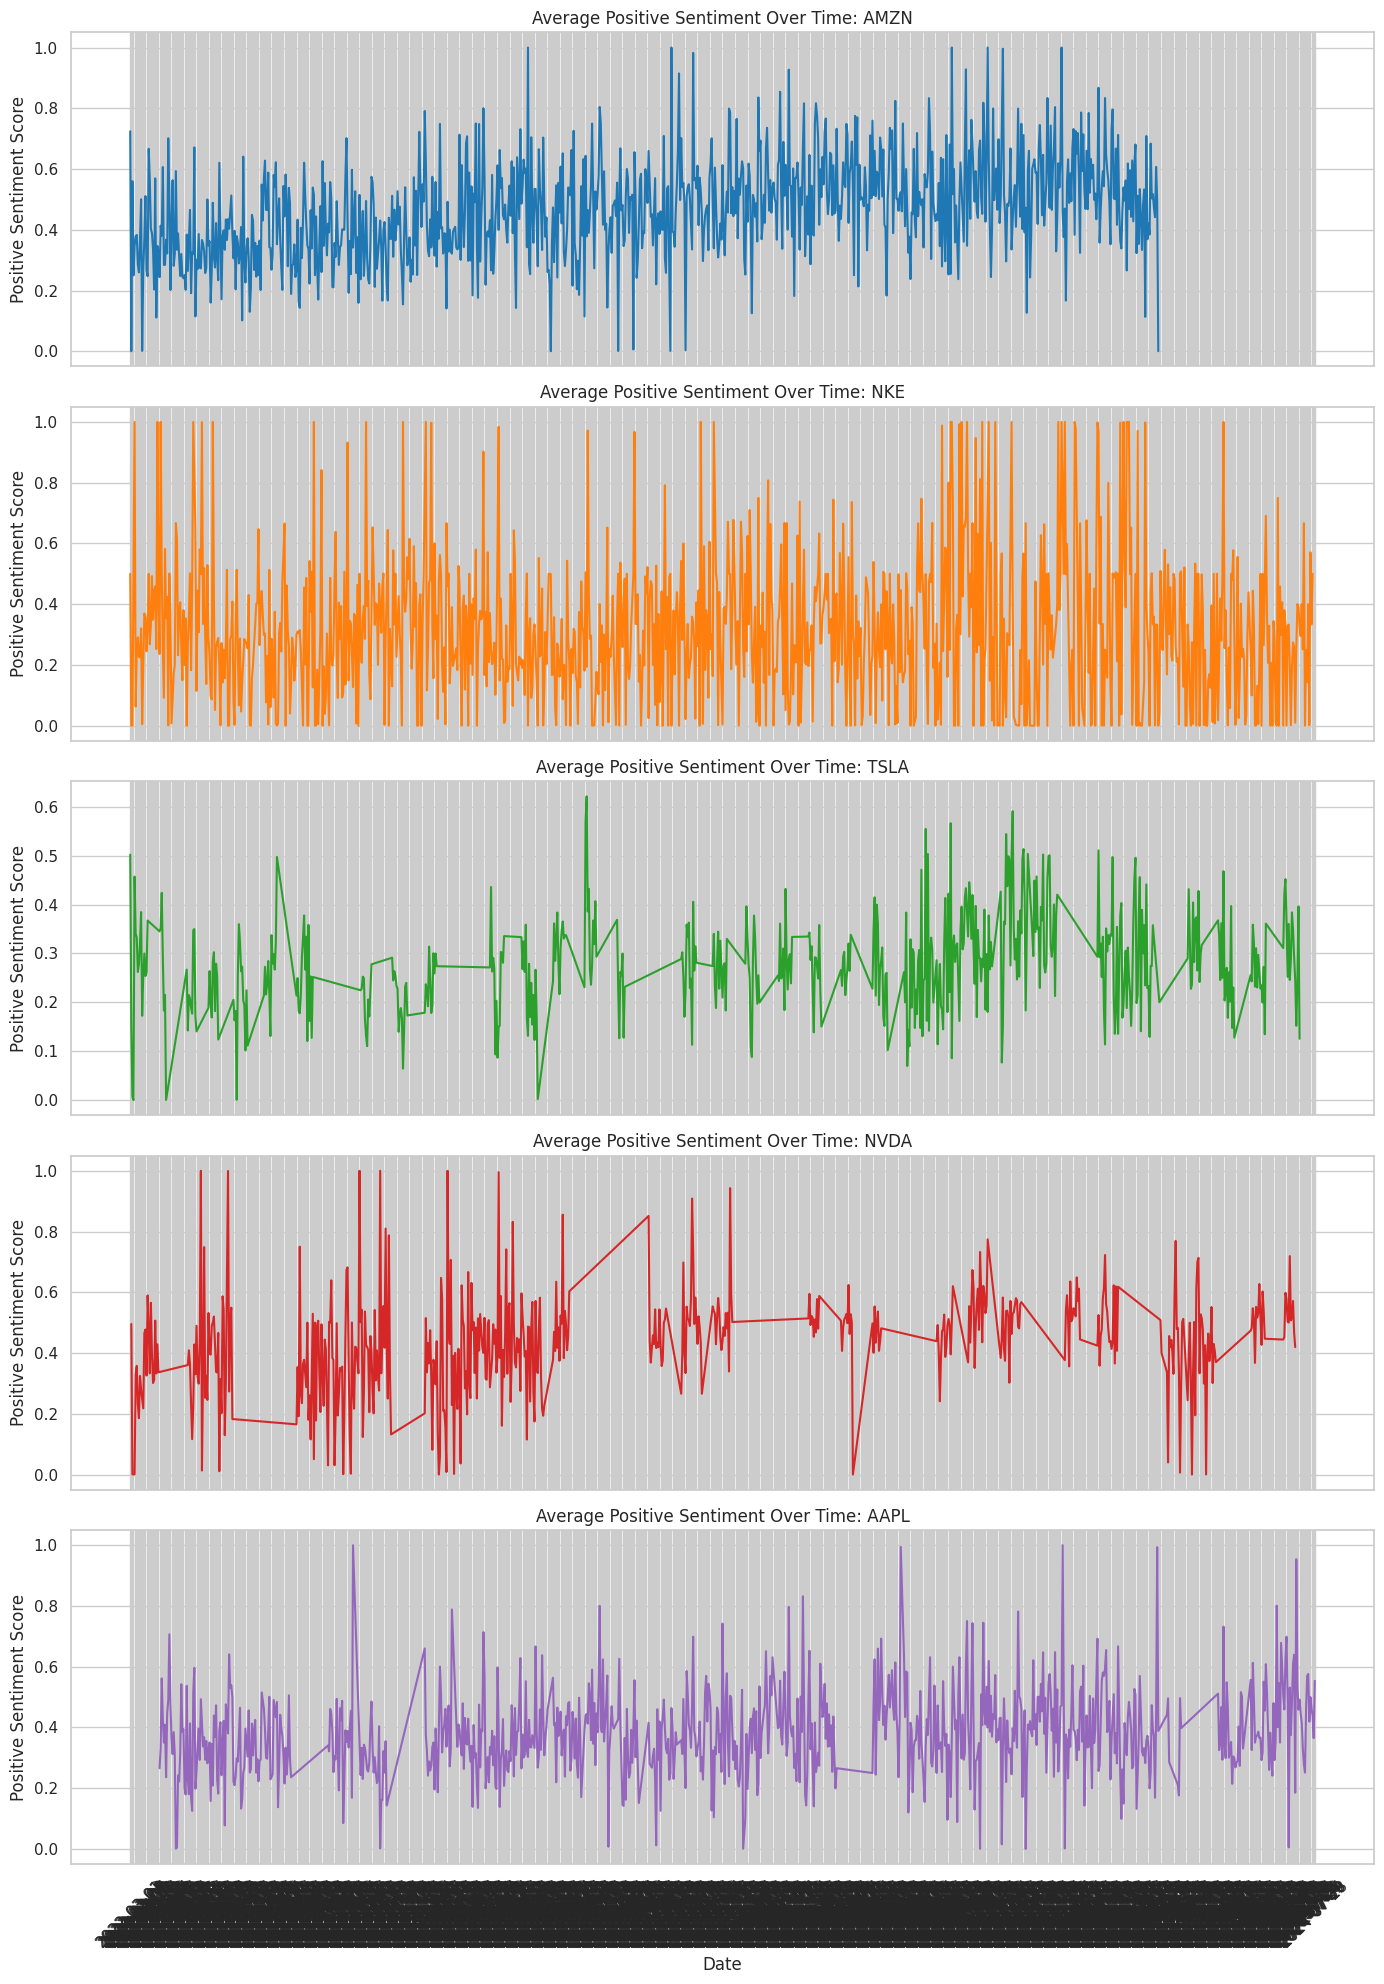

In [6]:
print(processed_dir)
# Group by date and ticker to get average sentiment per day
daily_sentiment = combined_df.groupby(['date', 'ticker'])[['sa_positive', 'sa_negative', 'sa_neutral']].mean().reset_index()

tickers = daily_sentiment['ticker'].unique()
n = len(tickers)
palette = sns.color_palette("tab10", n_colors=n)
fig, axes = plt.subplots(n, 1, figsize=(14, 4 * n), sharex=True)

if n == 1:
    axes = [axes]

for ax, ticker, color in zip(axes, tickers, palette):
    sns.lineplot(
        data=daily_sentiment[daily_sentiment['ticker'] == ticker],
        x="date", y="sa_positive", ax=ax, color=color
    )
    ax.set_title(f"Average Positive Sentiment Over Time: {ticker}")
    ax.set_xlabel("Date")
    ax.set_ylabel("Positive Sentiment Score")
    ax.tick_params(axis='x', rotation=45)

plt.tight_layout()
plt.show()

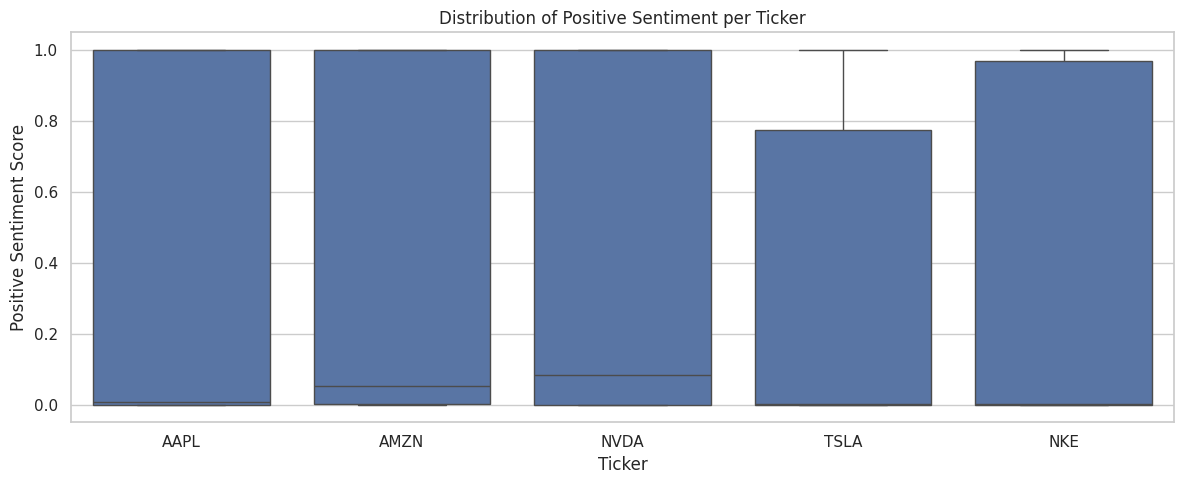

In [7]:
plt.figure(figsize=(12, 5))
sns.boxplot(data=combined_df, x="ticker", y="sa_positive")
plt.title("Distribution of Positive Sentiment per Ticker")
plt.ylabel("Positive Sentiment Score")
plt.xlabel("Ticker")
plt.tight_layout()
plt.show()


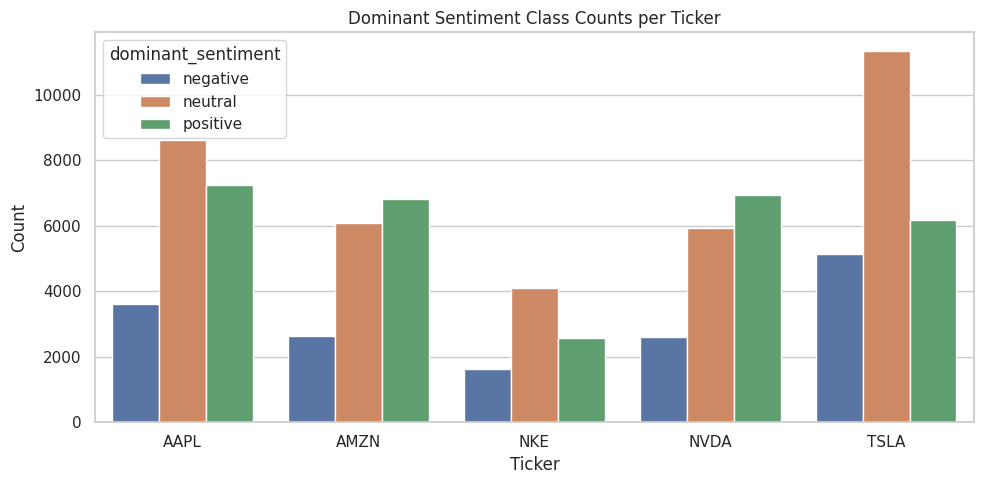

In [8]:
# Label each row by dominant sentiment
def label_sentiment(row):
    scores = {'positive': row['sa_positive'], 'negative': row['sa_negative'], 'neutral': row['sa_neutral']}
    return max(scores, key=scores.get)

combined_df['dominant_sentiment'] = combined_df.apply(label_sentiment, axis=1)

# Count of sentiments per ticker
sentiment_counts = combined_df.groupby(['ticker', 'dominant_sentiment']).size().reset_index(name='count')

plt.figure(figsize=(10, 5))
sns.barplot(data=sentiment_counts, x='ticker', y='count', hue='dominant_sentiment')
plt.title("Dominant Sentiment Class Counts per Ticker")
plt.xlabel("Ticker")
plt.ylabel("Count")
plt.tight_layout()
plt.show()


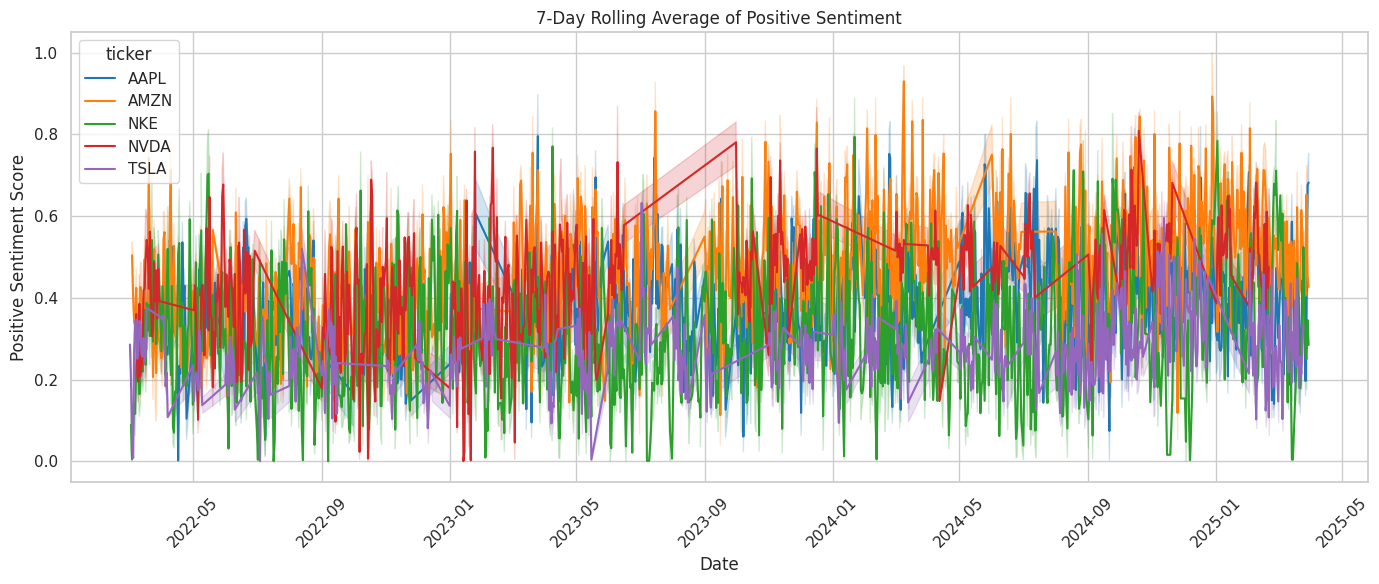

In [9]:
import matplotlib.pyplot as plt
import seaborn as sns

combined_df['date'] = pd.to_datetime(combined_df['date'])
rolling_df = (
    combined_df.sort_values('date')
    .groupby('ticker')
    .rolling(window=7, on='date')[['sa_positive']]
    .mean()
    .reset_index()
)

palette = sns.color_palette("tab10", n_colors=rolling_df['ticker'].nunique())

plt.figure(figsize=(14, 6))
sns.lineplot(
    data=rolling_df,
    x='date',
    y='sa_positive',
    hue='ticker',
    palette=palette
)
plt.title("7-Day Rolling Average of Positive Sentiment")
plt.xlabel("Date")
plt.ylabel("Positive Sentiment Score")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

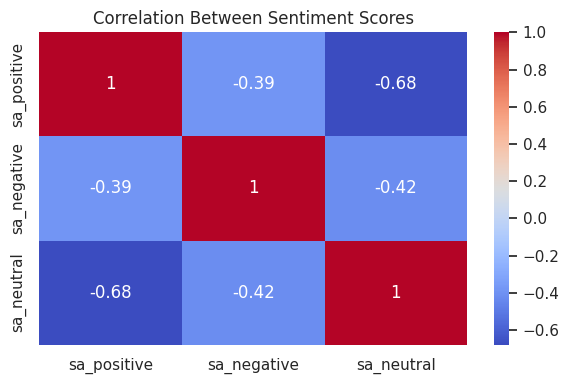

In [10]:
plt.figure(figsize=(6, 4))
sns.heatmap(combined_df[['sa_positive', 'sa_negative', 'sa_neutral']].corr(), annot=True, cmap='coolwarm')
plt.title("Correlation Between Sentiment Scores")
plt.tight_layout()
plt.show()


In [11]:
import pandas as pd
from pathlib import Path

TICKERS = ['AAPL', 'AMZN', 'NKE', 'NVDA', 'TSLA']

def process_ticker(ticker):
    # Read stock and news data
    stock_path = DATASET_DIR / 'stocks_cleaned' / f'{ticker}_yahoo_data_0.csv'
    news_path = DATASET_DIR / 'processed' / f'{ticker}_news_processed.csv'
    
    df_stock = pd.read_csv(stock_path, parse_dates=['Date'])
    df_news = pd.read_csv(news_path, parse_dates=['date'])

    # Standardize date format
    df_stock['date'] = df_stock['Date'].dt.date
    df_news['date'] = df_news['date'].dt.date

    # Aggregate news per day
    agg_funcs = {
        'ticker_sentiment_score': 'mean',
        'sa_positive': 'mean',
        'sa_negative': 'mean',
        'sa_neutral': 'mean',
        'title': lambda x: ' | '.join(x.dropna().astype(str)[:5]),
        'summary': lambda x: ' | '.join(x.dropna().astype(str)[:5]),
        'news_text': lambda x: ' | '.join(x.dropna().astype(str)[:2]),
        'ticker_sentiment_label': lambda x: x.mode().iloc[0] if not x.mode().empty else 'Neutral'
    }
    df_news_agg = df_news.groupby('date').agg(agg_funcs).reset_index()

    # Merge news into stock data
    merged = pd.merge(df_stock, df_news_agg, on='date', how='left')

    return merged

# Process all tickers and save to disk or analyze
all_data = {ticker: process_ticker(ticker) for ticker in TICKERS}


In [12]:
import pandas as pd
import numpy as np
from sklearn.linear_model import LinearRegression
import matplotlib.pyplot as plt
from scipy.stats import pearsonr

def compute_slope(series, window=5):
    slopes = []
    for i in range(len(series)):
        if i < window:
            slopes.append(np.nan)
        else:
            y = series[i-window:i].values.reshape(-1, 1)
            x = np.arange(window).reshape(-1, 1)
            model = LinearRegression().fit(x, y)
            slopes.append(model.coef_[0][0])
    return np.array(slopes)

def compare_trend_sentiment(df, ticker, price_col='Close'):
    df = df.sort_values('date').copy()
    
    # Compute slope of stock price
    df['slope'] = compute_slope(df[[price_col]], window=5)

    # Normalize both for plotting
    df['slope_norm'] = (df['slope'] - df['slope'].mean()) / df['slope'].std()
    df['sentiment_norm'] = (df['ticker_sentiment_score'] - df['ticker_sentiment_score'].mean()) / df['ticker_sentiment_score'].std()

    # Drop NA for correlation
    df_clean = df.dropna(subset=['slope_norm', 'sentiment_norm'])

    # Plot
    plt.figure(figsize=(12, 5))
    plt.plot(df_clean['date'], df_clean['slope_norm'], label='Price Slope (Normalized)', color='blue')
    plt.plot(df_clean['date'], df_clean['sentiment_norm'], label='Sentiment Score (Normalized)', color='orange')
    plt.title(f"{ticker}: Price Trend vs Sentiment")
    plt.xlabel("Date")
    plt.ylabel("Normalized Value")
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

    # Correlation
    corr, p_val = pearsonr(df_clean['slope_norm'], df_clean['sentiment_norm'])
    print(f"📊 Pearson Correlation between trend and sentiment for {ticker}: {corr:.4f} (p={p_val:.4e})")


Analyzing AAPL...


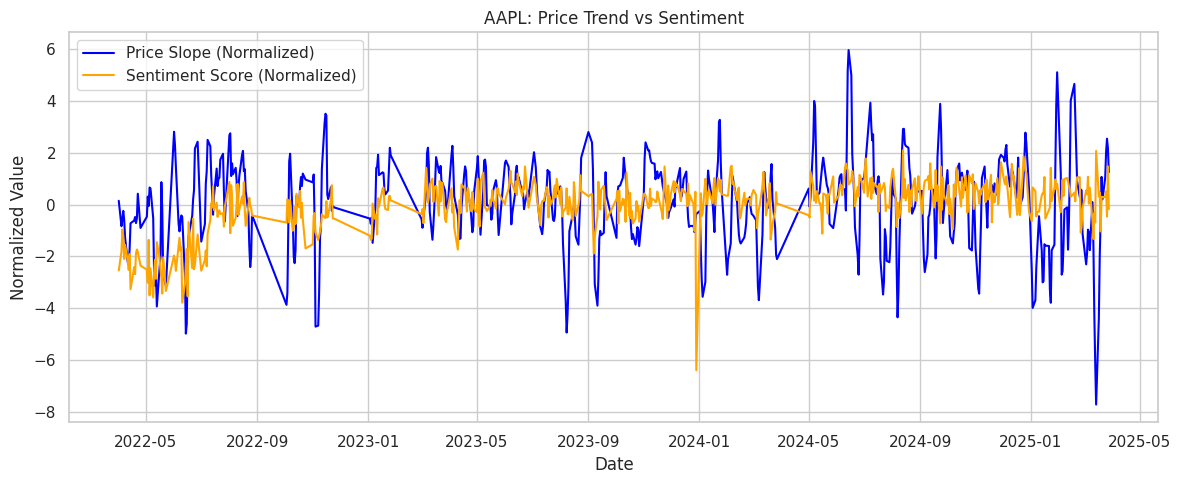

📊 Pearson Correlation between trend and sentiment for AAPL: 0.2015 (p=6.0851e-07)
Analyzing AMZN...


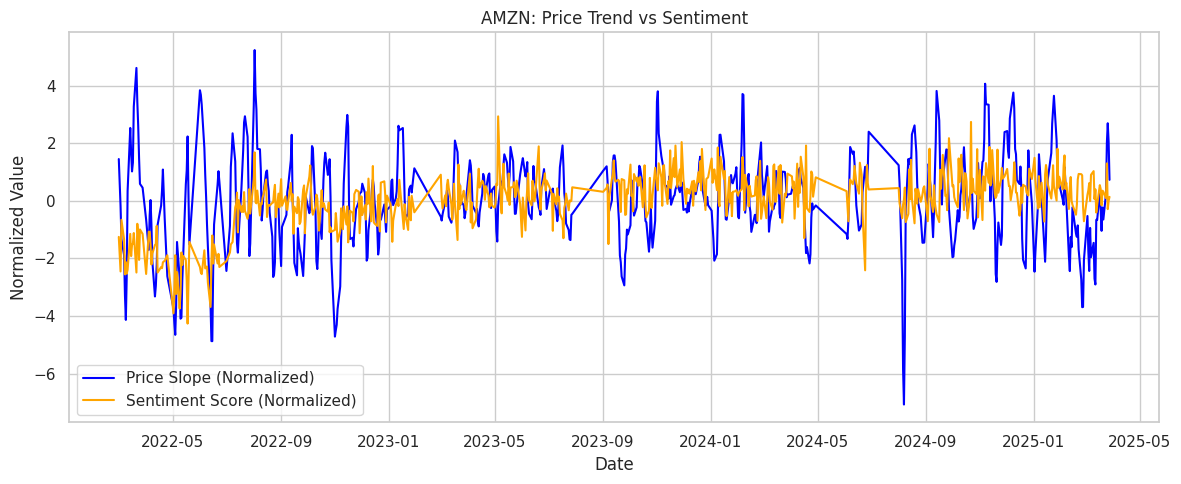

📊 Pearson Correlation between trend and sentiment for AMZN: 0.1673 (p=1.8658e-05)
Analyzing NKE...


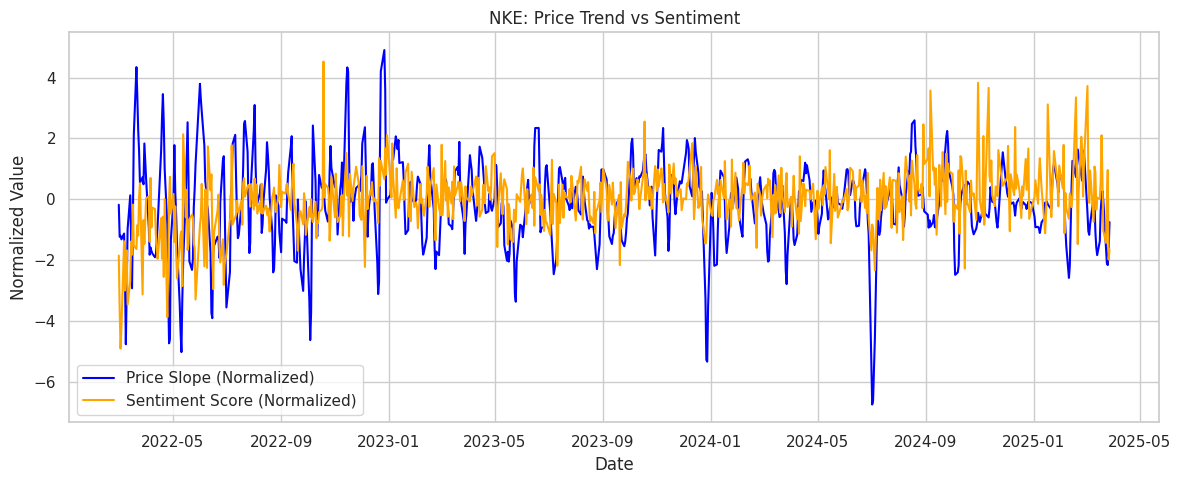

📊 Pearson Correlation between trend and sentiment for NKE: 0.1673 (p=4.9007e-06)
Analyzing NVDA...


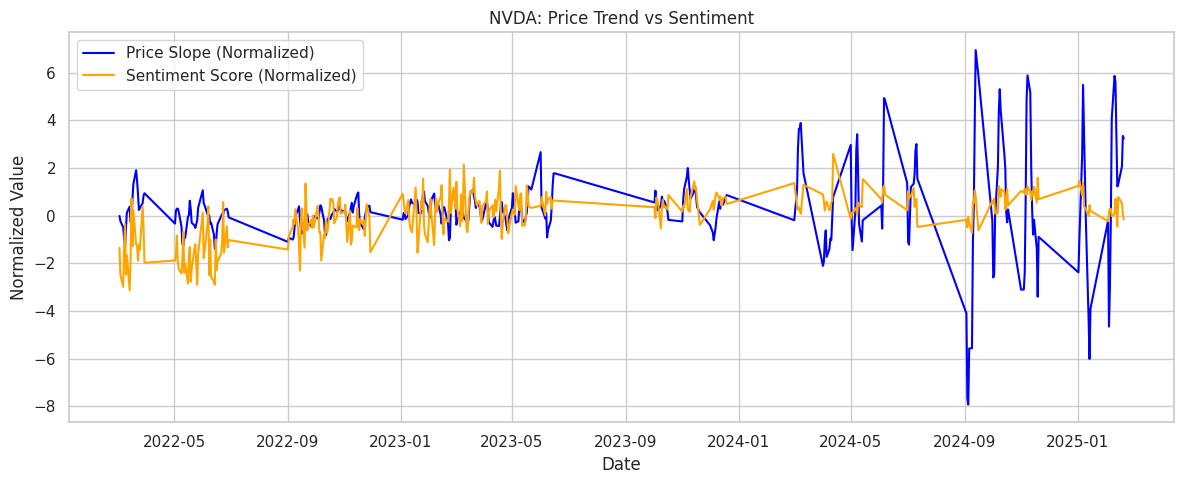

📊 Pearson Correlation between trend and sentiment for NVDA: 0.1564 (p=2.6979e-03)
Analyzing TSLA...


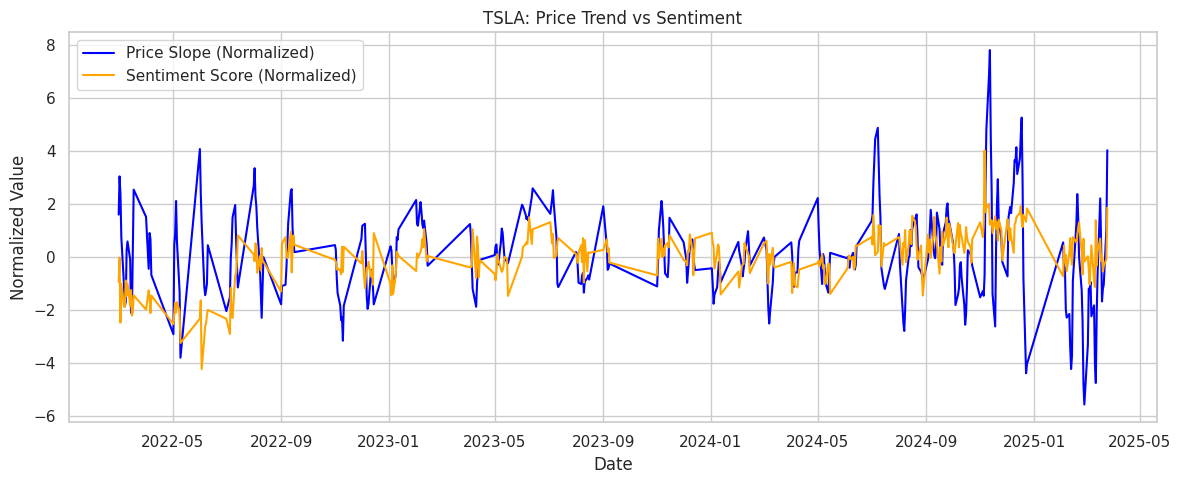

📊 Pearson Correlation between trend and sentiment for TSLA: 0.2298 (p=7.7983e-06)


In [13]:

for ticker in TICKERS:
    print(f"Analyzing {ticker}...")
    if ticker in all_data:
        compare_trend_sentiment(all_data[ticker], ticker)
    else:
        print(f"No data found for {ticker}.")
# compare_trend_sentiment(all_data['AAPL'], 'AAPL')


In [14]:
def lagged_correlation_analysis(df, ticker, max_lag=10, price_col='Close'):
    df = df.sort_values('date').copy()
    df['slope'] = compute_slope(df[[price_col]], window=5)
    df['slope_norm'] = (df['slope'] - df['slope'].mean()) / df['slope'].std()

    results = []

    for d in range(0, max_lag + 1):
        # Shift sentiment back by d days
        df[f'sentiment_lag{d}'] = df['ticker_sentiment_score'].shift(d)
        df[f'sentiment_lag{d}_norm'] = (df[f'sentiment_lag{d}'] - df[f'sentiment_lag{d}'].mean()) / df[f'sentiment_lag{d}'].std()

        df_clean = df.dropna(subset=[f'sentiment_lag{d}_norm', 'slope_norm'])
        corr, p = pearsonr(df_clean[f'sentiment_lag{d}_norm'], df_clean['slope_norm'])
        results.append((d, corr, p))

    # Print
    for d, corr, p in results:
        print(f"Lag {d}: Pearson Correlation = {corr:.4f} (p={p:.2e})")

    return results

for ticker in TICKERS:
    print(f"Analyzing lagged correlation for {ticker}...")
    if ticker in all_data:
        lagged_correlation_analysis(all_data[ticker], ticker)
    else:
        print(f"No data found for {ticker}.")

Analyzing lagged correlation for AAPL...
Lag 0: Pearson Correlation = 0.2015 (p=6.09e-07)
Lag 1: Pearson Correlation = 0.2839 (p=1.27e-12)
Lag 2: Pearson Correlation = 0.3164 (p=1.93e-15)
Lag 3: Pearson Correlation = 0.2822 (p=1.90e-12)
Lag 4: Pearson Correlation = 0.1838 (p=5.94e-06)
Lag 5: Pearson Correlation = 0.1054 (p=9.87e-03)
Lag 6: Pearson Correlation = 0.0704 (p=8.56e-02)
Lag 7: Pearson Correlation = 0.0583 (p=1.55e-01)
Lag 8: Pearson Correlation = 0.0483 (p=2.39e-01)
Lag 9: Pearson Correlation = 0.0280 (p=4.96e-01)
Lag 10: Pearson Correlation = 0.0113 (p=7.83e-01)
Analyzing lagged correlation for AMZN...
Lag 0: Pearson Correlation = 0.1673 (p=1.87e-05)
Lag 1: Pearson Correlation = 0.2111 (p=5.96e-08)
Lag 2: Pearson Correlation = 0.2043 (p=1.61e-07)
Lag 3: Pearson Correlation = 0.1770 (p=6.10e-06)
Lag 4: Pearson Correlation = 0.1666 (p=2.14e-05)
Lag 5: Pearson Correlation = 0.1502 (p=1.32e-04)
Lag 6: Pearson Correlation = 0.1372 (p=4.91e-04)
Lag 7: Pearson Correlation = 0.0882

In [15]:
def plot_lagged_correlations(results, ticker):
    lags = [r[0] for r in results]
    corrs = [r[1] for r in results]

    plt.figure(figsize=(8, 5))
    plt.plot(lags, corrs, marker='o', linestyle='-', color='green')
    plt.title(f"{ticker} — Lagged Sentiment vs Price Trend Correlation")
    plt.xlabel("Lag (days behind)")
    plt.ylabel("Pearson Correlation")
    plt.grid(True)
    plt.axhline(0, linestyle='--', color='gray')
    plt.tight_layout()
    plt.show()

Plotting lagged correlations for AAPL...
Lag 0: Pearson Correlation = 0.2015 (p=6.09e-07)
Lag 1: Pearson Correlation = 0.2839 (p=1.27e-12)
Lag 2: Pearson Correlation = 0.3164 (p=1.93e-15)
Lag 3: Pearson Correlation = 0.2822 (p=1.90e-12)
Lag 4: Pearson Correlation = 0.1838 (p=5.94e-06)
Lag 5: Pearson Correlation = 0.1054 (p=9.87e-03)
Lag 6: Pearson Correlation = 0.0704 (p=8.56e-02)
Lag 7: Pearson Correlation = 0.0583 (p=1.55e-01)
Lag 8: Pearson Correlation = 0.0483 (p=2.39e-01)
Lag 9: Pearson Correlation = 0.0280 (p=4.96e-01)
Lag 10: Pearson Correlation = 0.0113 (p=7.83e-01)


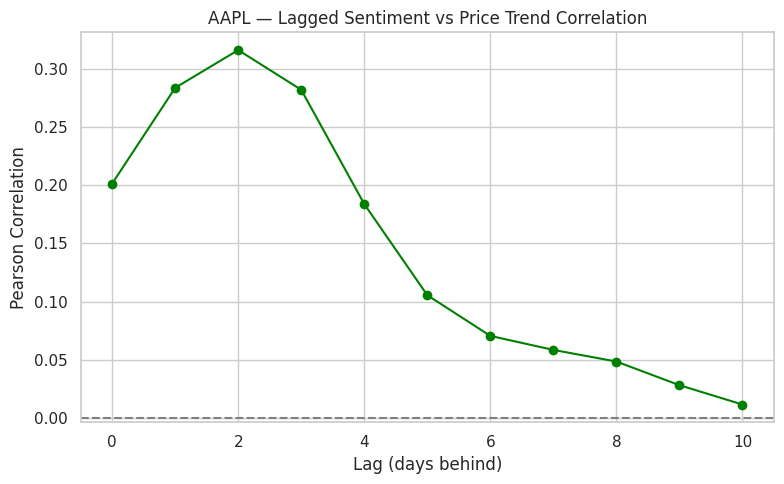

Plotting lagged correlations for AMZN...
Lag 0: Pearson Correlation = 0.1673 (p=1.87e-05)
Lag 1: Pearson Correlation = 0.2111 (p=5.96e-08)
Lag 2: Pearson Correlation = 0.2043 (p=1.61e-07)
Lag 3: Pearson Correlation = 0.1770 (p=6.10e-06)
Lag 4: Pearson Correlation = 0.1666 (p=2.14e-05)
Lag 5: Pearson Correlation = 0.1502 (p=1.32e-04)
Lag 6: Pearson Correlation = 0.1372 (p=4.91e-04)
Lag 7: Pearson Correlation = 0.0882 (p=2.55e-02)
Lag 8: Pearson Correlation = 0.0360 (p=3.63e-01)
Lag 9: Pearson Correlation = 0.0083 (p=8.35e-01)
Lag 10: Pearson Correlation = -0.0008 (p=9.83e-01)


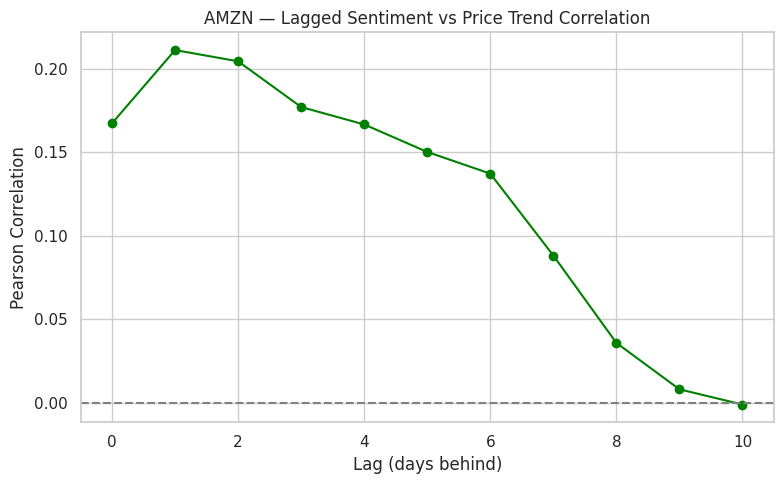

Plotting lagged correlations for NKE...
Lag 0: Pearson Correlation = 0.1673 (p=4.90e-06)
Lag 1: Pearson Correlation = 0.1992 (p=4.97e-08)
Lag 2: Pearson Correlation = 0.2046 (p=2.13e-08)
Lag 3: Pearson Correlation = 0.1817 (p=7.12e-07)
Lag 4: Pearson Correlation = 0.1170 (p=1.50e-03)
Lag 5: Pearson Correlation = 0.0613 (p=9.73e-02)
Lag 6: Pearson Correlation = 0.0239 (p=5.18e-01)
Lag 7: Pearson Correlation = -0.0032 (p=9.30e-01)
Lag 8: Pearson Correlation = -0.0032 (p=9.31e-01)
Lag 9: Pearson Correlation = 0.0267 (p=4.71e-01)
Lag 10: Pearson Correlation = 0.0593 (p=1.10e-01)


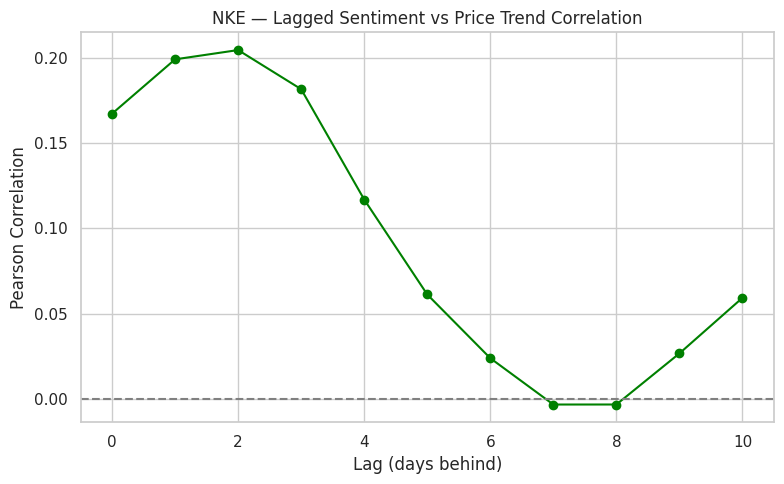

Plotting lagged correlations for NVDA...
Lag 0: Pearson Correlation = 0.1564 (p=2.70e-03)
Lag 1: Pearson Correlation = 0.2275 (p=1.11e-05)
Lag 2: Pearson Correlation = 0.2602 (p=4.46e-07)
Lag 3: Pearson Correlation = 0.2222 (p=1.79e-05)
Lag 4: Pearson Correlation = 0.1054 (p=4.38e-02)
Lag 5: Pearson Correlation = 0.0171 (p=7.44e-01)
Lag 6: Pearson Correlation = -0.0312 (p=5.51e-01)
Lag 7: Pearson Correlation = -0.0342 (p=5.15e-01)
Lag 8: Pearson Correlation = 0.0147 (p=7.79e-01)
Lag 9: Pearson Correlation = 0.0242 (p=6.45e-01)
Lag 10: Pearson Correlation = 0.0421 (p=4.22e-01)


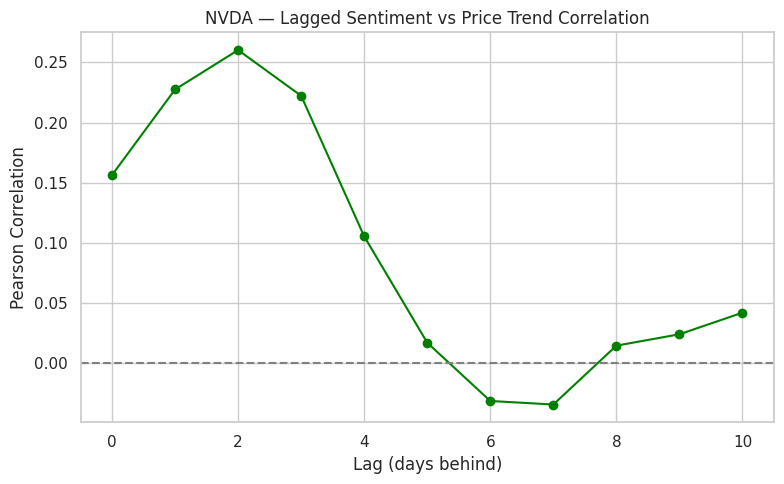

Plotting lagged correlations for TSLA...
Lag 0: Pearson Correlation = 0.2298 (p=7.80e-06)
Lag 1: Pearson Correlation = 0.3060 (p=1.76e-09)
Lag 2: Pearson Correlation = 0.3122 (p=7.86e-10)
Lag 3: Pearson Correlation = 0.2870 (p=1.83e-08)
Lag 4: Pearson Correlation = 0.2126 (p=3.75e-05)
Lag 5: Pearson Correlation = 0.1385 (p=7.71e-03)
Lag 6: Pearson Correlation = 0.1184 (p=2.31e-02)
Lag 7: Pearson Correlation = 0.0727 (p=1.65e-01)
Lag 8: Pearson Correlation = 0.0432 (p=4.10e-01)
Lag 9: Pearson Correlation = 0.0059 (p=9.11e-01)
Lag 10: Pearson Correlation = -0.0409 (p=4.37e-01)


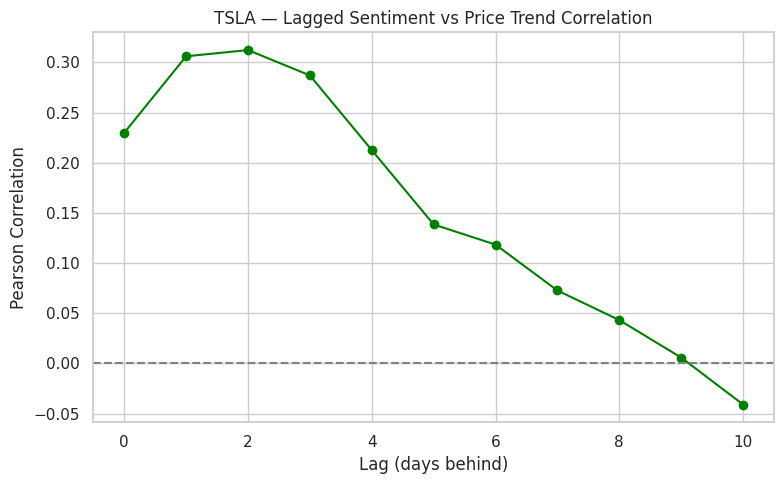

In [16]:
for ticker in TICKERS:
    print(f"Plotting lagged correlations for {ticker}...")
    if ticker in all_data:
        results = lagged_correlation_analysis(all_data[ticker], ticker)
        plot_lagged_correlations(results, ticker)
    else:
        print(f"No data found for {ticker}.")